In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
if os.environ.get('OS','') == 'Windows_NT':
    sys.path.append('c:/projects/python/mriprog/CardioMiner')
else:
    sys.path.append('~/projects/python/mriprog/CardioMiner')

In [3]:

import pickle 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import model_training_and_eval as mte
import orgim_scr as oi
import pydicom

2.10.0


In [4]:
sys.version

'3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]'

1 DATA SETS

Read DICOM tags

In [5]:
stud = 'PM' # PM or haglag
prm = oi.userGetOrg(stud)


In [6]:
prm.keys()

dict_keys(['stud', 'usr', 'vrb', 'Pt', 'drecs', 'PDLink', 'gr', 'sv', 'Input', 'Tbl', 'Ptsgm', 'drecssgm', 'inf', 'Inf', 'filepath', 'filepathDel'])

In [7]:

p = prm['Pt'][2]
p = 2
# p can be integer of p for pth entry into Pt or the string directly  
idx = oi.ptidx(prm,p) 


In [8]:
p = 2
idx = oi.ptidx(prm,p)
drecs = [prm['drecs'][i] for i in idx]
#print(prm['Pt'][p])
#print(drecs)

In [9]:
drecs = prm['drecs'][0]
dcmf = os.path.join(prm['filepath'],drecs).replace('\\','/')
ds = pydicom.dcmread(dcmf)
img = pydicom.read_file(dcmf)

In [10]:
float(ds.RescaleSlope)
float(ds.RescaleIntercept)
img.pixel_array*float(ds.RescaleSlope) + float(ds.RescaleIntercept)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
#  NewValue = (RawPixelValue * RescaleSlope) + RescaleIntercept
ds[0x00281054]

(0028, 1054) Rescale Type                        LO: 'normalized'

In [12]:
# Get information for pth entry
mv, ba, bs, hb, imx, imx_n, img = oi.maxval(prm,0,True)


Size 512x512 SamplesperPixel 1, Max pixel value 142


In [13]:
# Get the extra info for all patients - S is saved internally
ld = True
vrb = False
S = oi.get_pixvalinfo(prm, ld, vrb)

In [14]:
#prm['Tbl'][0]

Extract patches for training and testing model

In [15]:
# Run this to extract data for PM dataset. Other options are haglag and vxvy
if False:
    %run python -m get_images_and_masks -d PM

In [16]:
P_PATH = 'P:/data/mri/patches'
data_g = [g for g in os.listdir(P_PATH) if 'grouped' in g]
data_v = [g for g in os.listdir(P_PATH) if 'validation' in g]
data_p = [g for g in os.listdir(P_PATH) if 'presplit' in g]
print(data_g)
print(data_v)
print(data_p)


['PM_test_patients_0_15_grouped.p', 'haglag_test_patients_0_15_grouped.p']
['PM_imgs_and_Mmyo_0_15_validation.p', 'haglag_imgs_and_Mmyo_0_15_validation.p']
['PM_presplit.p', 'haglag_presplit.p']


In [17]:
STUDY = ['PM', 'haglag']
DATA = {}
for s in STUDY:
    DATA[s] = [g for g in os.listdir(P_PATH) if s in g]
DATA

{'PM': ['PM_test_patients_0_15_grouped.p',
  'PM_imgs_and_Mmyo_0_15_validation.p',
  'PM_presplit.p'],
 'haglag': ['haglag_test_patients_0_15_grouped.p',
  'haglag_imgs_and_Mmyo_0_15_validation.p',
  'haglag_presplit.p']}

In [18]:
s = 'PM'
d_p = [d for d in DATA[s] if 'presplit' in d][0]
d_g = [d for d in DATA[s] if 'grouped' in d][0]
d_v = [d for d in DATA[s] if 'validation' in d][0]
d_p

'PM_presplit.p'

In [19]:
PICKLE_PATH = os.path.join(P_PATH,d_g)

1.1 EXPLORING PRESPLIT DATA

As described in explanation of pred_patient_set in model_training_and_eval.py

     {'ABC1': [
        [img1, img2, img3, img4, ...],
        [mask1, mask2, mask3, mask4, ...],
        ],
     'DEF2': [
        [img1, img2, img3, img4, ...],
        [mask1, mask2, mask3, mask4, ...],
        ],
     'GHI3': [
        ...
     ]
    }

In [20]:
with open(PICKLE_PATH, "rb") as input_file:
    data = pickle.load(input_file)

In [21]:
PICKLE_PATH

'P:/data/mri/patches\\PM_test_patients_0_15_grouped.p'

In [22]:
Pt = [*data.keys()]
print(Pt)

['PM123', 'PM240', 'PM271', 'PM346', 'PM295', 'PM136', 'PM321', 'PM188', 'PM325', 'PM105', 'PM068', 'PM014', 'PM072', 'PM304', 'PM064', 'PM330', 'PM176', 'PM110', 'PM149', 'PM255', 'PM209', 'PM267', 'PM074', 'PM099', 'PM340', 'PM324', 'PM139', 'PM298', 'PM277', 'PM310', 'PM038', 'PM317', 'PM131', 'PM269', 'PM039', 'PM132', 'PM080', 'PM067', 'PM273', 'PM069', 'PM023', 'PM061', 'PM009', 'PM322', 'PM160', 'PM319', 'PM090', 'PM152', 'PM060', 'PM036', 'PM191', 'PM259', 'PM182', 'PM171', 'PM113', 'PM084', 'PM199', 'PM287']



k, i = 0, 2
Pt[k] = 'PM123'
img  = data['PM123'][0][2] (image #2 size (256, 256))
mask = data['PM123'][1][2] (mask  #2 size (256, 256))


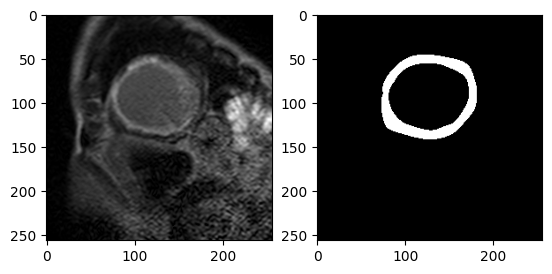

In [23]:
k, i = 0, 2
img = data[Pt[k]][0][i]
mask = data[Pt[k]][1][i]
print(f'\nk, i = 0, 2')
print(f"Pt[k] = '{Pt[k]}'")
print(f"img  = data['{Pt[k]}'][0][{i}] (image #{i} size {img.shape})")
print(f"mask = data['{Pt[k]}'][1][{i}] (mask  #{i} size {mask.shape})")

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')

In [24]:
print(f'\nUnique pixel values \n{np.unique(img)}\n')
print(f'Unique mask values \n{np.unique(mask)}\n')
print(f'Pixel value range \n{int(np.min(img))}-{int(np.max(img))}\n')


Unique pixel values 
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192.

In [25]:
len(data[Pt[0]][0])

9

In [26]:
len(Pt)

58

In [27]:
def pix_stat(data, vrb=False):
    Pt = [*data.keys()]
    SCL = np.ones(len(Pt))
    SCLf = np.ones(len(Pt))
    SCLc = np.ones(len(Pt))
    MAX = np.ones(len(Pt))
    MIN = np.ones(len(Pt))
    for k in range(len(Pt)):
        pix = []
        for i in range(len(data[Pt[k]][0])):
            img = data[Pt[k]][0][i]
            #print(f"   {i} img  = data['{Pt[k]}'][0][{i}] (image #{i} size {img.shape}) Max pixval {int(np.max(data[Pt[k]][0][i]))} Jaccard {jac[i]}")
            #pix.append(img.ravel())
            pix.append(np.max(img))
        if vrb:
            print(f'{Pt[k]} Pixel max range: {np.min(pix):0.0f}-{np.max(pix):0.0f} \n')
        MAX[k] = np.max(pix)
        SCL[k] = 2**np.round(np.log2(MAX[k]))
        SCLf[k] = 2**np.floor(np.log2(MAX[k]))
        SCLc[k] = 2**np.ceil(np.log2(MAX[k]))
        MIN[k] = np.min(pix)


    df_pix = pd.DataFrame({'Pt': Pt, 'Pixel max': MAX.astype(int), 'Pixel scale': SCL, 'Pixel scale floor': SCLf , 'Pixel scale ceil': SCLc})
    return df_pix
df_pix = pix_stat(data)
df_pix

,Pt,Pixel max,Pixel scale,Pixel scale floor,Pixel scale ceil
0,PM123,262,256.0,256.0,512.0
1,PM240,271,256.0,256.0,512.0
2,PM271,291,256.0,256.0,512.0
3,PM346,186,256.0,128.0,256.0
4,PM295,214,256.0,128.0,256.0
5,PM136,280,256.0,256.0,512.0
6,PM321,123,128.0,64.0,128.0
7,PM188,154,128.0,128.0,256.0
8,PM325,208,256.0,128.0,256.0
9,PM105,204,256.0,128.0,256.0


In [28]:
scl_mets = ['256', 'Pixel scale', 'Pixel scale floor', 'Pixel scale ceil', 'Pixel max'] # Actual column names in df_pix
models = ['res_mod', 'mul_mod']
mets = ['256', 'round', 'floor', 'ceil', 'max' ]

In [29]:
def data_scl(data, scl_met):
    vrb = False
    Pt = [*data.keys()]
    df_pix = pix_stat(data) #pd.read_pickle('df_pix.p')
    import copy
    datan = copy.deepcopy(data)

    for k in range(len(Pt)):
        if vrb:
            print(f"\nPt[k] = '{Pt[k]}'")
        if scl_met != '256':
            scl = df_pix[df_pix['Pt'] == Pt[k]][scl_met].to_numpy()[0]
        else:
            scl = 256
        for i in range(len(data[Pt[k]][0])):
            img = data[Pt[k]][0][i]
            mask = data[Pt[k]][1][i]
            datan[Pt[k]][0][i] = datan[Pt[k]][0][i]/scl
            if vrb:
                print(f"   {i} img  = data['{Pt[k]}'][0][{i}] (image #{i} size {img.shape}) Pixel value range {int(np.min(data[Pt[k]][0][i]))}-{int(np.max(data[Pt[k]][0][i]))}")
                print(f"   {i} img  = data['{Pt[k]}'][0][{i}] (image #{i} size {img.shape}) Scale {scl}       {(np.max(datan[Pt[k]][0][i])):0.2f}")
                print(f"   {i} mask = data['{Pt[k]}'][1][{i}] (mask  #{i} size {mask.shape})")

    #print(f'Normalised data with {scl_met}')
    return datan
datan = data_scl(data, scl_mets[0])

In [30]:
scl_mets[0]

'256'

2. THE TRAINED MODELS

In [31]:
MODELS = [f for f in os.listdir() if '.h' in f]
res_mod = [f for f in os.listdir() if 'residual.h' in f][0]
mul_mod = [f for f in os.listdir() if 'multires.h' in f][0]
print(f'res_mod = {res_mod}')
print(f'mul_mod = {mul_mod}')


res_mod = best_model_residual.h5
mul_mod = best_model_multires.h5


3. RUNNING THE MODEL

In [32]:
#[*data.keys()]

In [33]:
print(scl_mets)
print(mets)

['256', 'Pixel scale', 'Pixel scale floor', 'Pixel scale ceil', 'Pixel max']
['256', 'round', 'floor', 'ceil', 'max']


In [34]:
def pred_data(data, scl_met, mod='res_mod', ld=True):
    print(f'Predicting with {mod}, data scaling, {scl_met}')
    model = {'res_mod': 'best_model_residual.h5', 'mul_mod': 'best_model_multires.h5'}
    resfile = f'PMet_{mod}_{scl_met}_PM.p'
    svdir = f'c:/EKG/segm/{mod}/{scl_met}'
    Path(svdir).mkdir(parents=True, exist_ok=True)
    datan = data_scl(data, scl_met)
    if not os.path.isfile(resfile) or not ld:
        print('Predicting data and saving')
        PMet = mte.pred_patient_set(model[mod], datan, 'test',  svdir, thr)
        with open(resfile, "wb") as fp:
            pickle.dump(PMet,fp)
    else:
        print('Loading data')
        with open(resfile, "rb") as fp:
            PMet = pickle.load(fp)
    return PMet
PMet = pred_data(data, scl_mets[-1], 'res_mod')

Predicting with res_mod, data scaling, Pixel max
Loading data


In [35]:
def pred_pt(data, scl_met, mod='res_mod', thr=0.5):
    print(f'Predicting with {mod}, data scaling, {scl_met}')
    model = {'res_mod': 'best_model_residual.h5', 'mul_mod': 'best_model_multires.h5'}
    resfile = f'PMet_{mod}_{scl_met}_PM.p'
    svdir = f'c:/EKG/segm/{mod}/{scl_met}_{thr*100:.0f}'
    Path(svdir).mkdir(parents=True, exist_ok=True)
    datan = data_scl(data, scl_met)
    PMet = mte.pred_patient_set(model[mod], datan, 'test',  svdir, thr)
    return PMet
Pt = 'PM009'
PMet = pred_pt({Pt: data[Pt]}, scl_mets[0], 'res_mod', 0.7)

Predicting with res_mod, data scaling, 256


1:1 Predicting with test on PM009


In [36]:
for model in models:
    for scl_met in scl_mets:
        PMet = pred_data(data, scl_met, model, True)

Predicting with res_mod, data scaling, 256
Loading data
Predicting with res_mod, data scaling, Pixel scale


Loading data
Predicting with res_mod, data scaling, Pixel scale floor
Loading data
Predicting with res_mod, data scaling, Pixel scale ceil


Loading data
Predicting with res_mod, data scaling, Pixel max
Loading data
Predicting with mul_mod, data scaling, 256


Loading data
Predicting with mul_mod, data scaling, Pixel scale
Loading data
Predicting with mul_mod, data scaling, Pixel scale floor


Loading data
Predicting with mul_mod, data scaling, Pixel scale ceil
Loading data
Predicting with mul_mod, data scaling, Pixel max


Loading data


In [37]:
PMet.keys()

dict_keys(['PM123', 'PM240', 'PM271', 'PM346', 'PM295', 'PM136', 'PM321', 'PM188', 'PM325', 'PM105', 'PM068', 'PM014', 'PM072', 'PM304', 'PM064', 'PM330', 'PM176', 'PM110', 'PM149', 'PM255', 'PM209', 'PM267', 'PM074', 'PM099', 'PM340', 'PM324', 'PM139', 'PM298', 'PM277', 'PM310', 'PM038', 'PM317', 'PM131', 'PM269', 'PM039', 'PM132', 'PM080', 'PM067', 'PM273', 'PM069', 'PM023', 'PM061', 'PM009', 'PM322', 'PM160', 'PM319', 'PM090', 'PM152', 'PM060', 'PM036', 'PM191', 'PM259', 'PM182', 'PM171', 'PM113', 'PM084', 'PM199', 'PM287'])

In [38]:
S.keys()

dict_keys(['Pt', 'min', 'max', 'slices'])

In [39]:
#S['slices'][0]['PM009']

In [40]:

S2 = {'Pt': [], 'max': [], 'file': []}
for i, p in enumerate(S['Pt']):
    if i < 10:
        print(f'{i} {p}')
        M = len(S['slices'][i][p]['max'])
        for k in range(M):
            S2['Pt'].append(p)
            S2['max'].append(S['slices'][i][p]['max'][k])
            S2['file'].append(S['slices'][i][p]['file'][k])

#pd.DataFrame({'Pt': S2['Pt'], 'max': S2['max'], 'file': S2['file'][k]})
        

0 PM009
1 PM010
2 PM011
3 PM013
4 PM014
5 PM016
6 PM017
7 PM018
8 PM019
9 PM020


In [41]:
Pt = [*data.keys()]
print(Pt)

['PM123', 'PM240', 'PM271', 'PM346', 'PM295', 'PM136', 'PM321', 'PM188', 'PM325', 'PM105', 'PM068', 'PM014', 'PM072', 'PM304', 'PM064', 'PM330', 'PM176', 'PM110', 'PM149', 'PM255', 'PM209', 'PM267', 'PM074', 'PM099', 'PM340', 'PM324', 'PM139', 'PM298', 'PM277', 'PM310', 'PM038', 'PM317', 'PM131', 'PM269', 'PM039', 'PM132', 'PM080', 'PM067', 'PM273', 'PM069', 'PM023', 'PM061', 'PM009', 'PM322', 'PM160', 'PM319', 'PM090', 'PM152', 'PM060', 'PM036', 'PM191', 'PM259', 'PM182', 'PM171', 'PM113', 'PM084', 'PM199', 'PM287']


In [42]:
stud

'PM'

In [43]:
img.ravel()

array([ 4.,  3.,  2., ..., 35., 30., 14.])

In [44]:
mets

['256', 'round', 'floor', 'ceil', 'max']

In [45]:
def resfile_gen(model, met, stud):
    sclmet = 'Pixel scale'
    if met == '256':
        sclmet = '256'
    elif met != 'round':
        sclmet = f'{sclmet} {met}'

    if met == 'max':
        print(sclmet)
        sclmet = sclmet.replace(' scale','')
    resfile = f'PMet_{model}_{sclmet}_{stud}.p'
    return resfile
resfile_gen(models[0], mets[0], stud)

'PMet_res_mod_256_PM.p'

In [46]:
def resfiles_gen(models, mets, stud):
    resfiles = []
    for model in models:
        for met in mets:
            resfiles.append(resfile_gen(model, met, stud))
    return resfiles

resfiles = resfiles_gen([models[0]], mets, stud)
resfiles
    



Pixel scale max


['PMet_res_mod_256_PM.p',
 'PMet_res_mod_Pixel scale_PM.p',
 'PMet_res_mod_Pixel scale floor_PM.p',
 'PMet_res_mod_Pixel scale ceil_PM.p',
 'PMet_res_mod_Pixel max_PM.p']

In [47]:

def df_perf_gen(PMet, vrb=False):
    Pt = [*PMet.keys()]
    JAC = np.ones(len(Pt))
    SCL = np.ones(len(Pt))
    SCLf = np.ones(len(Pt))
    SCLc = np.ones(len(Pt))
    MAX = np.ones(len(Pt))
    MIN = np.ones(len(Pt))
    for k in range(len(Pt)):
        jac = np.array(PMet[Pt[k]]['jaccard'])
        JAC[k] = np.mean(jac)
        pix = []
        for i in range(len(data[Pt[k]][0])):
            img = data[Pt[k]][0][i]
            #print(f"   {i} img  = data['{Pt[k]}'][0][{i}] (image #{i} size {img.shape}) Max pixval {int(np.max(data[Pt[k]][0][i]))} Jaccard {jac[i]}")
            #pix.append(img.ravel())
            pix.append(np.max(img))
        if vrb:
            print(f'{Pt[k]} Pixel max range: {np.min(pix):0.0f}-{np.max(pix):0.0f} Jaccard mean(min-max): {np.mean(jac):0.2f}({np.min(jac):0.2f}-{np.max(jac):0.2f}) \n')
        MAX[k] = np.max(pix)
        SCL[k] = 2**np.round(np.log2(MAX[k]))
        SCLf[k] = 2**np.floor(np.log2(MAX[k]))
        SCLc[k] = 2**np.ceil(np.log2(MAX[k]))
        MIN[k] = np.min(pix)


    df_pix = pd.DataFrame({'Pt': Pt, 'Pixel max': MAX.astype(int), 'Pixel scale': SCL, 'Pixel scale floor': SCLf , 'Pixel scale ceil': SCLc,'Jaccard': JAC})
    return df_pix
df_pix = df_perf_gen(PMet)
df_pix

,Pt,Pixel max,Pixel scale,Pixel scale floor,Pixel scale ceil,Jaccard
0,PM123,262,256.0,256.0,512.0,0.583778
1,PM240,271,256.0,256.0,512.0,0.232167
2,PM271,291,256.0,256.0,512.0,0.480833
3,PM346,186,256.0,128.0,256.0,0.615857
4,PM295,214,256.0,128.0,256.0,0.517500
5,PM136,280,256.0,256.0,512.0,0.786125
6,PM321,123,128.0,64.0,128.0,0.744857
7,PM188,154,128.0,128.0,256.0,0.465714
8,PM325,208,256.0,128.0,256.0,0.599429
9,PM105,204,256.0,128.0,256.0,0.776000


In [48]:
resfiles

['PMet_res_mod_256_PM.p',
 'PMet_res_mod_Pixel scale_PM.p',
 'PMet_res_mod_Pixel scale floor_PM.p',
 'PMet_res_mod_Pixel scale ceil_PM.p',
 'PMet_res_mod_Pixel max_PM.p']

In [49]:
resfiles = resfiles_gen([models[0]], mets, stud)
df = pd.DataFrame([])
for i, resfile in enumerate(resfiles[0:5]):
    #print(f'{i} {resfile}')
    with open(resfile, "rb") as fp:
        PMet = pickle.load(fp)
    if i == 0:
        df_pix = df_perf_gen(PMet)
    else:
        df = df_perf_gen(PMet)
        df_pix = df_pix.merge(df[['Pt', 'Jaccard']], how='left', left_on='Pt', right_on='Pt')
        df_pix = df_pix.rename({'Jaccard_x': 'Jaccard', 'Jaccard_y': f'Jaccard_{mets[i][0]}'}, axis='columns')

df_pix[['Pt', 'Pixel max', 'Jaccard', 'Jaccard_r', 'Jaccard_f', 'Jaccard_c', 'Jaccard_m']].sort_values(by=['Jaccard'])

Pixel scale max


,Pt,Pixel max,Jaccard,Jaccard_r,Jaccard_f,Jaccard_c,Jaccard_m
19,PM255,138,0.072500,0.168833,0.168833,0.072500,0.158333
21,PM267,117,0.116714,0.198143,0.292714,0.198143,0.214857
36,PM080,163,0.216625,0.343625,0.343625,0.216625,0.326625
43,PM322,210,0.219818,0.219818,0.382818,0.219818,0.283727
35,PM132,104,0.230429,0.289571,0.221286,0.289571,0.272571
18,PM149,81,0.235400,0.207600,0.207600,0.254000,0.234200
51,PM259,536,0.259750,0.055125,0.055125,0.001375,0.044125
1,PM240,271,0.264833,0.264833,0.264833,0.130667,0.261833
16,PM176,231,0.311750,0.311750,0.490625,0.311750,0.344750
45,PM319,332,0.347286,0.347286,0.347286,0.252857,0.285857


In [50]:
def present_results(model, mets, stud):
    resfiles = resfiles_gen([model], mets, stud)
    df = pd.DataFrame([])
    for i, resfile in enumerate(resfiles[0:5]):
        #print(f'{i} {resfile}')
        with open(resfile, "rb") as fp:
            PMet = pickle.load(fp)
        if i == 0:
            df_res = df_perf_gen(PMet)
        else:
            df = df_perf_gen(PMet)
            df_res = df_res.merge(df[['Pt', 'Jaccard']], how='left', left_on='Pt', right_on='Pt')
            df_res = df_res.rename({'Jaccard_x': 'Jaccard', 'Jaccard_y': f'Jaccard_{mets[i][0]}'}, axis='columns')
    return df_res
df_res = present_results(models[0], mets, stud )
df_res[['Pt', 'Pixel max', 'Jaccard', 'Jaccard_r', 'Jaccard_f', 'Jaccard_c', 'Jaccard_m']].sort_values(by=['Jaccard'])

Pixel scale max


,Pt,Pixel max,Jaccard,Jaccard_r,Jaccard_f,Jaccard_c,Jaccard_m
19,PM255,138,0.072500,0.168833,0.168833,0.072500,0.158333
21,PM267,117,0.116714,0.198143,0.292714,0.198143,0.214857
36,PM080,163,0.216625,0.343625,0.343625,0.216625,0.326625
43,PM322,210,0.219818,0.219818,0.382818,0.219818,0.283727
35,PM132,104,0.230429,0.289571,0.221286,0.289571,0.272571
18,PM149,81,0.235400,0.207600,0.207600,0.254000,0.234200
51,PM259,536,0.259750,0.055125,0.055125,0.001375,0.044125
1,PM240,271,0.264833,0.264833,0.264833,0.130667,0.261833
16,PM176,231,0.311750,0.311750,0.490625,0.311750,0.344750
45,PM319,332,0.347286,0.347286,0.347286,0.252857,0.285857


In [51]:
df_pix[['Jaccard', 'Jaccard_r', 'Jaccard_f', 'Jaccard_c', 'Jaccard_m']].quantile([0.05, .25, .5, .75, 0.95])

,Jaccard,Jaccard_r,Jaccard_f,Jaccard_c,Jaccard_m
0.05,0.219339,0.206181,0.219233,0.146722,0.231299
0.25,0.428071,0.396677,0.435125,0.348125,0.404769
0.50,0.586238,0.593634,0.610007,0.531172,0.585008
0.75,0.683665,0.669406,0.688250,0.680594,0.677813
0.95,0.774075,0.773751,0.773751,0.766896,0.772437


In [52]:
i = 0
df_res = present_results(models[i], mets, stud )
print(f'\nRESULTS for {models[i]}')
print(df_res[['Pt', 'Pixel max', 'Jaccard', 'Jaccard_r', 'Jaccard_f', 'Jaccard_c', 'Jaccard_m']].sort_values(by=['Jaccard']).round(decimals=2))
print(f'\nSummarised in percentiles for {models[i]}')
print(df_res[['Jaccard', 'Jaccard_r', 'Jaccard_f', 'Jaccard_c', 'Jaccard_m']].quantile([0.05, .25, .5, .75, 0.95]).round(decimals=2))

Pixel scale max

RESULTS for res_mod
       Pt  Pixel max  Jaccard  Jaccard_r  Jaccard_f  Jaccard_c  Jaccard_m
19  PM255        138     0.07       0.17       0.17       0.07       0.16
21  PM267        117     0.12       0.20       0.29       0.20       0.21
36  PM080        163     0.22       0.34       0.34       0.22       0.33
43  PM322        210     0.22       0.22       0.38       0.22       0.28
35  PM132        104     0.23       0.29       0.22       0.29       0.27
18  PM149         81     0.24       0.21       0.21       0.25       0.23
51  PM259        536     0.26       0.06       0.06       0.00       0.04
1   PM240        271     0.26       0.26       0.26       0.13       0.26
16  PM176        231     0.31       0.31       0.49       0.31       0.34
45  PM319        332     0.35       0.35       0.35       0.25       0.29
4   PM295        214     0.37       0.37       0.42       0.37       0.40
27  PM298        332     0.38       0.38       0.38       0.29       0.35
1

In [53]:
df = {}
for i in range(2):
    df_res = present_results(models[i], mets, stud )
    print(f'\nRESULTS for {models[i]}')
    print(df_res[['Pt', 'Pixel max', 'Jaccard', 'Jaccard_r', 'Jaccard_f', 'Jaccard_c', 'Jaccard_m']].sort_values(by=['Jaccard']).round(decimals=2))
    print(f'\nSummarised in percentiles for {models[i]}')
    print(df_res[['Jaccard', 'Jaccard_r', 'Jaccard_f', 'Jaccard_c', 'Jaccard_m']].quantile([0.05, .25, .5, .75, 0.95]).round(decimals=2))
    print(df_res[['Jaccard', 'Jaccard_r', 'Jaccard_f', 'Jaccard_c', 'Jaccard_m']].describe().round(decimals=2))
    df[models[i]] = df_res

Pixel scale max

RESULTS for res_mod
       Pt  Pixel max  Jaccard  Jaccard_r  Jaccard_f  Jaccard_c  Jaccard_m
19  PM255        138     0.07       0.17       0.17       0.07       0.16
21  PM267        117     0.12       0.20       0.29       0.20       0.21
36  PM080        163     0.22       0.34       0.34       0.22       0.33
43  PM322        210     0.22       0.22       0.38       0.22       0.28
35  PM132        104     0.23       0.29       0.22       0.29       0.27
18  PM149         81     0.24       0.21       0.21       0.25       0.23
51  PM259        536     0.26       0.06       0.06       0.00       0.04
1   PM240        271     0.26       0.26       0.26       0.13       0.26
16  PM176        231     0.31       0.31       0.49       0.31       0.34
45  PM319        332     0.35       0.35       0.35       0.25       0.29
4   PM295        214     0.37       0.37       0.42       0.37       0.40
27  PM298        332     0.38       0.38       0.38       0.29       0.35
1

In [54]:
len(data.keys())

58

In [55]:
metsd = {'8': '256', 'r': 'Pixel scale', 'f': 'Pixel scale floor', 'c': 'Pixel scale ceil', 'm': 'Pixel max'}

In [56]:
Pt = 'PM149'

svdir = 'C:/EKG/segm'
fil = f"{svdir}/mul_mod/{metsd['8']}/Pred_{Pt}.png"
fil

'C:/EKG/segm/mul_mod/256/Pred_PM149.png'

In [57]:

%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [58]:
# Default settings for figures
fsz = np.array([6,4])*3
rcParams['figure.figsize'] = tuple(fsz) #(6, 4) # Default (6, 4)
rcParams['figure.facecolor'] = 'black'

In [59]:
scl_mets

['256', 'Pixel scale', 'Pixel scale floor', 'Pixel scale ceil', 'Pixel max']

In [63]:
def pred_pt(data, scl_met, mod='res_mod', thr=0.5):
    Pt == [*data.keys()][0]
    print(f'Predicting with {mod}, data scaling, {scl_met}')
    model = {'res_mod': 'best_model_residual.h5', 'mul_mod': 'best_model_multires.h5'}
    resfile = f'PMet_{mod}_{scl_met}_PM.p'
    svdir = f'c:/EKG/segm/{mod}/{scl_met}_{thr*100:.0f}'
    Path(svdir).mkdir(parents=True, exist_ok=True)
    datan = data_scl(data, scl_met)
    PMet = mte.pred_patient_set(model[mod], datan, 'test',  svdir, thr)
    fil = f'{svdir}/Pred_{Pt}.png'
    if True:
        img = mpimg.imread(fil)
        imgplot = plt.imshow(img)
        plt.show()
    return PMet


PM255
Predicting with res_mod, data scaling, 256


1:1 Predicting with test on PM255


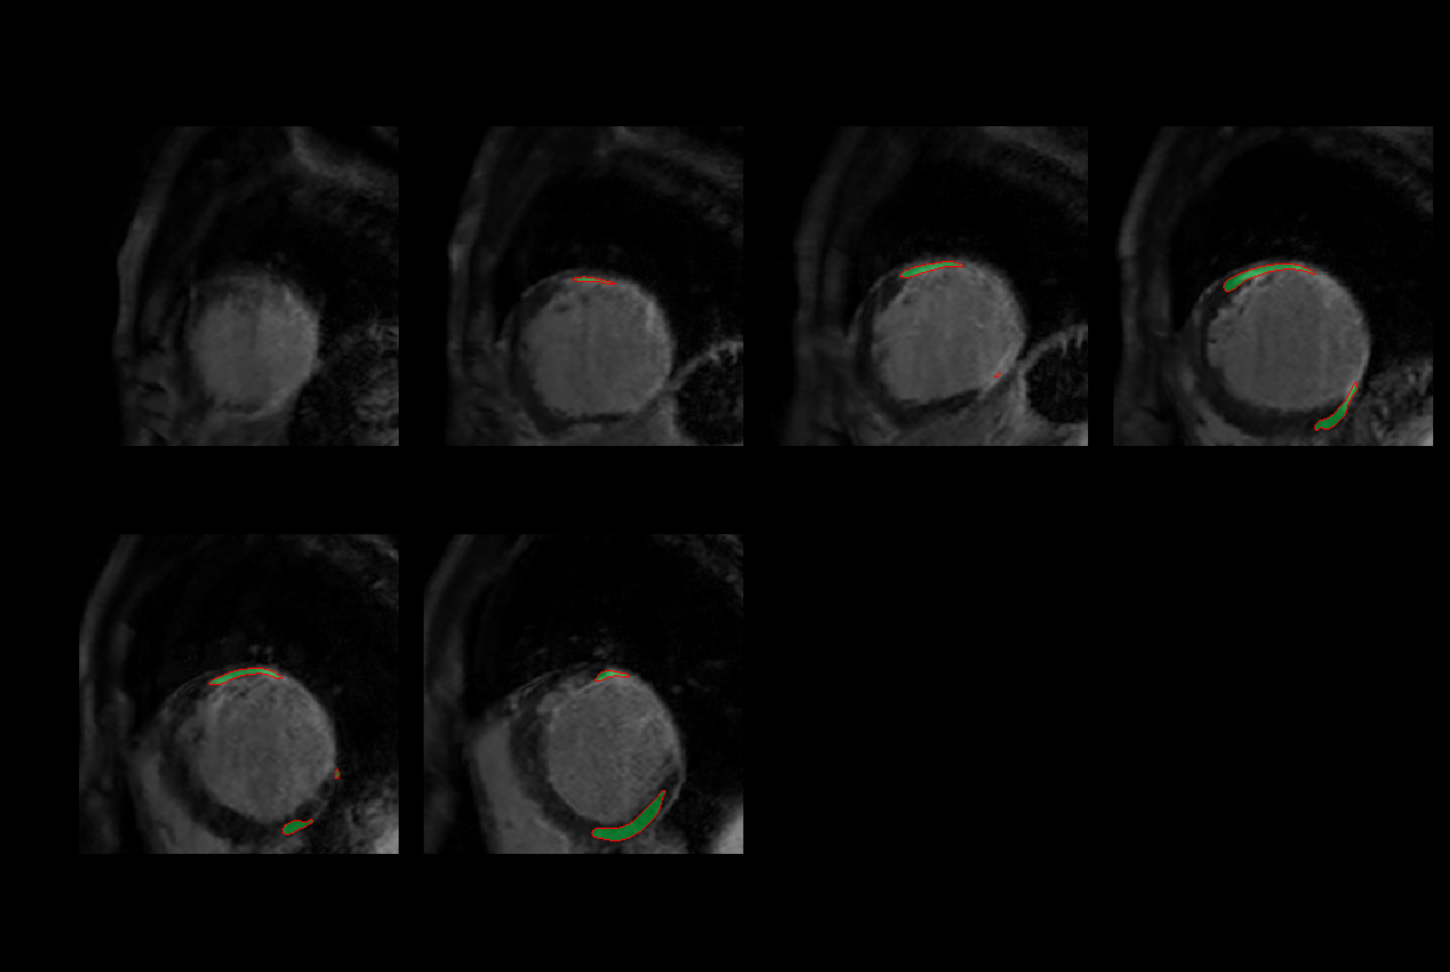

{'jaccard': [0.0, 0.027, 0.059, 0.144, 0.079, 0.126], 'dice': [0.0, 0.053, 0.112, 0.253, 0.147, 0.224]}

PM255
Predicting with mul_mod, data scaling, Pixel scale floor


1:1 Predicting with test on PM255


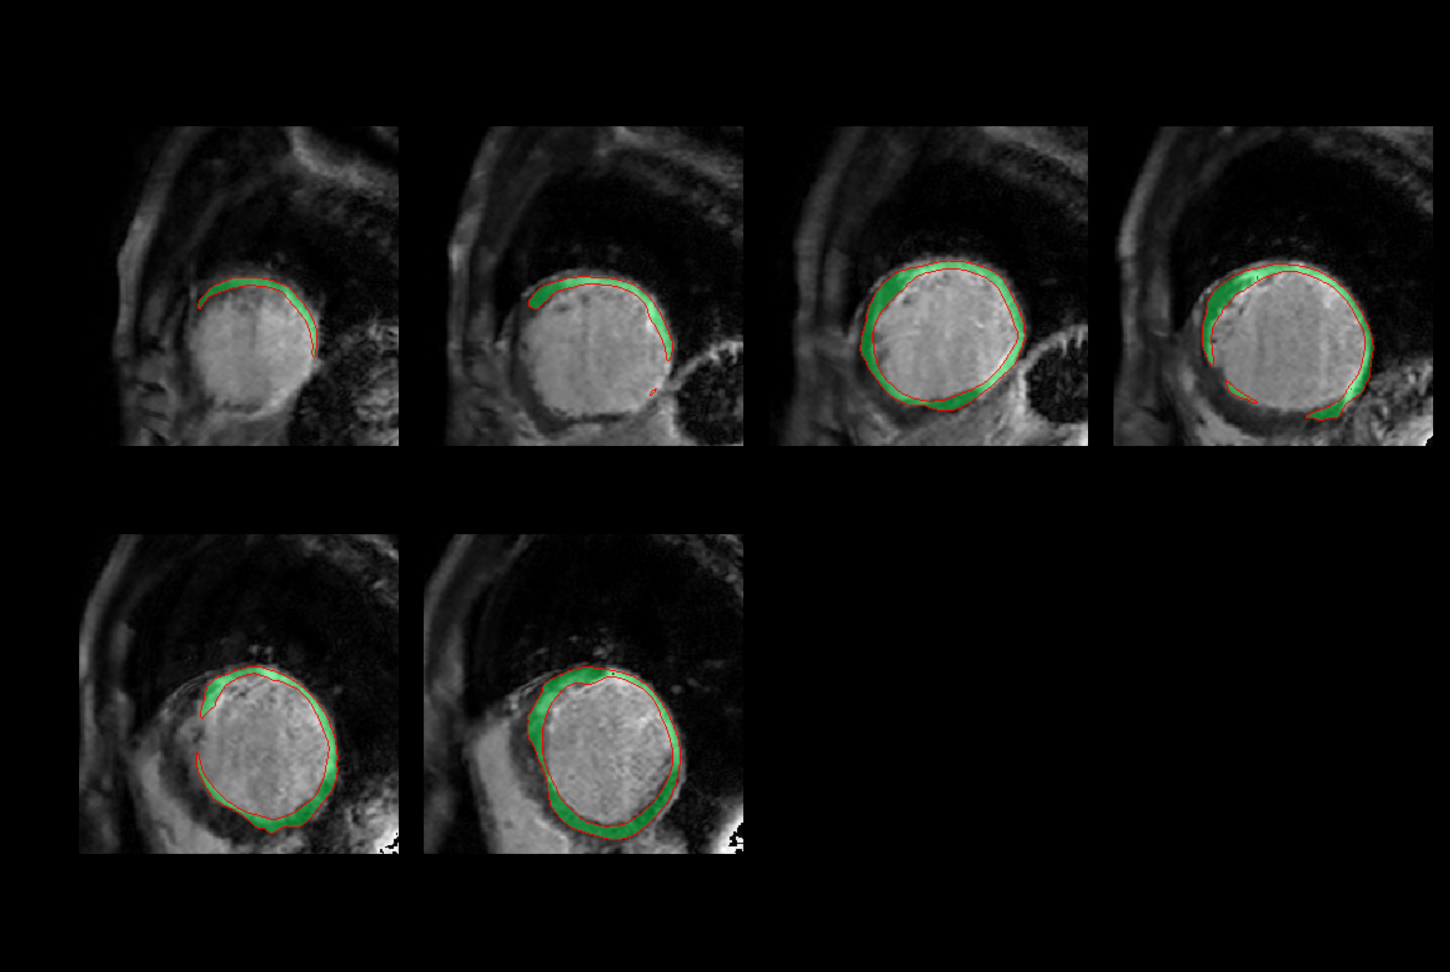

{'jaccard': [0.229, 0.288, 0.479, 0.372, 0.299, 0.529], 'dice': [0.373, 0.447, 0.648, 0.543, 0.46, 0.692]}


In [76]:
Pt = 'PM149'
Pt = 'PM176'
Pt = 'PM269'
#Pt = 'PM113'
Pt = [*data.keys()][19]
print(f'\n{Pt}')
PMet = pred_pt({Pt: data[Pt]}, scl_mets[0], 'res_mod', 0.5)
print(PMet[Pt])
print(f'\n{Pt}')
PMet = pred_pt({Pt: data[Pt]}, scl_mets[2], 'mul_mod', 0.5)
print(PMet[Pt])